In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
import pickle


file_id = "1KF0yBrF2_FcdJ1XhFyUsjYAHJC7qMpVl"
output_file = "data_DoS.csv"

if not os.path.exists(output_file):
    gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output_file, quiet=False)

file_id = "1_GXC-sVehXrvsLDHVHie6fdeIISlBV2z"
output_file = "data_Web.csv"

if not os.path.exists(output_file):
    gdown.download(f"https://drive.google.com/uc?id={file_id}&confirm=t", output_file, quiet=False)

# Load the data
data_DoS = pd.read_csv("data_DoS.csv")
data_Web = pd.read_csv("data_Web.csv")

#concatenate the data
data = pd.concat([data_DoS, data_Web])

# Display the first 5 rows of the data
data.head()


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


##### Exploratory Data Analysis

In [2]:
print(f"Features: {data.columns[:-1]}")
print(f"Target: {data.columns[-1]}")

print(f"Number of data points: {len(data)}")

print(f"Number of features: {len(data.columns) - 1}")


Features: Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Va

In [3]:
#handle NaN values
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()

counts = data[data.columns[-1]].value_counts()
print(counts)

 Label
BENIGN                        607734
DoS Hulk                      230124
DoS GoldenEye                  10293
DoS slowloris                   5796
DoS Slowhttptest                5499
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64


 Label
BENIGN                        607734
DoS Hulk                      230124
DoS GoldenEye                  10293
DoS slowloris                   5796
DoS Slowhttptest                5499
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64


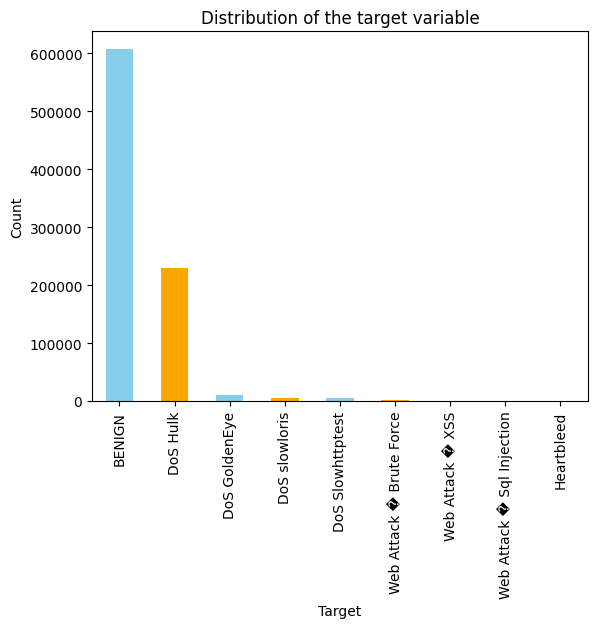

In [4]:
# Check for class imbalances
# Display the distribution of the target variable
counts = data[data.columns[-1]].value_counts()
print(counts)
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of the target variable')
plt.show()

We want to focus specifially on DoS attacks, so we will filter out the Heartbleed, one because it is not a DoS attack and two because it is only present 11 times.

In addition, we will also combine the different types of DoS attacks into one category, as DoS Hulk (HTTP-Unbearable-Load-King) is the most common and greatly outnumber the other classes of DoS attacks present in the dataset.

To attempt to account for some of the class imbalance, we will combine the different types of Web Attacks as well.

 Label
BENIGN        607734
DoS           607734
Web Attack    607734
Name: count, dtype: int64


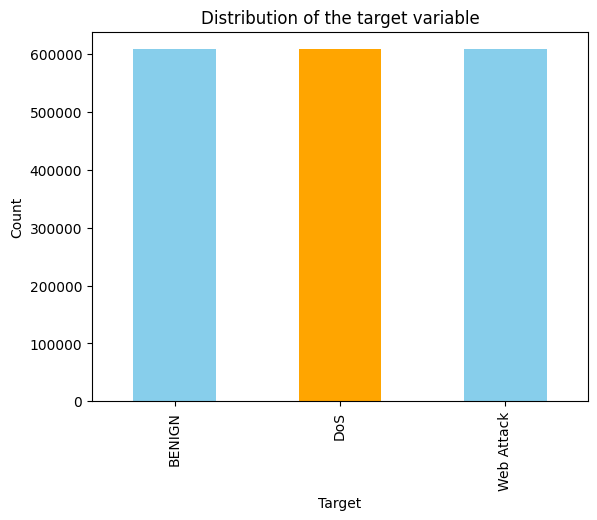

In [5]:
#handle class imbalance
#remove rows with class "Heartbleed"
data = data[data[data.columns[-1]] != "Heartbleed"]

#combine all remaining DoS classes into one class
data[data.columns[-1]] = data[data.columns[-1]].replace(["DoS Hulk", "DoS GoldenEye", "DoS slowloris", "DoS Slowhttptest"], "DoS")
data[data.columns[-1]] = data[data.columns[-1]].replace(["Web Attack � Brute Force", "Web Attack � XSS", "Web Attack � Sql Injection"], "Web Attack")

# Run SMOTE to upsample Web Attack class
from imblearn.over_sampling import SMOTE

# Separate the features and target variable
X = data[data.columns[:-1]]
y = data[data.columns[-1]]

# Apply SMOTE
smote = SMOTE(sampling_strategy='not majority')
X, y = smote.fit_resample(X, y)

# Display the distribution of the target variable after SMOTE
counts = y.value_counts()
print(counts)

# Display the distribution of the target variable
counts.plot(kind='bar', color=['skyblue', 'orange'])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of the target variable')
plt.show()

In [6]:
# Run ANOVA F-test to select the top k features
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2

# Select the top 10 features
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Get the selected feature indices
selected_features = selector.get_support(indices=True)

# Get the selected feature names
X.columns[selected_features]

# Display the selected features
selected_features = X.columns[selected_features]
print(selected_features)



c:\Users\speed\anaconda3\envs\pytorch-gpu2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [31 32 33 49 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\speed\anaconda3\envs\pytorch-gpu2\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Index(['Bwd Packet Length Max', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Packet Length Std', ' PSH Flag Count',
       ' Avg Bwd Segment Size', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', 'Idle Mean', ' Idle Max'],
      dtype='object')


We can see based on the selected features that Packet Length is responsible for a majority of the variance, which makes sense as the size of the packet is a key feature in determining a given attack.

{dtype('O'), dtype('int64'), dtype('float64')}
[8.19788200e-01 8.49176075e-02 3.92243774e-02 3.14611140e-02
 1.34373827e-02 4.59146369e-03 2.81577437e-03 1.25933335e-03
 5.82380455e-04 5.40908052e-04 4.84794217e-04 3.30252130e-04
 1.92574873e-04 1.12691822e-04 9.73889608e-05 5.05968699e-05
 4.49667175e-05 2.06368170e-05 1.25280220e-05 1.22288747e-05
 1.03293722e-05 7.59058345e-06 2.00164477e-06 1.36686814e-06
 7.86033323e-07 5.61644105e-07 6.62620163e-08 6.49253658e-08
 1.16670587e-08 9.55722690e-09 4.57429144e-09 2.94523056e-09
 1.84684087e-09 6.08379043e-10 4.88742838e-11 4.67776737e-11
 1.90005639e-11 1.28318204e-11 6.16150248e-12 9.84275724e-13
 5.54807039e-13 3.14383124e-13 2.46442137e-13 1.38412286e-13
 1.11145525e-13 7.95794502e-14 4.59049841e-14 2.20690413e-14
 1.00261618e-14 5.97449183e-15 2.30909437e-15 1.68019528e-15
 6.87791568e-16 3.99906556e-17 1.67217771e-17 9.18266355e-18
 8.22929501e-18 4.66155137e-18 2.57479563e-18 2.04036659e-18
 1.72556423e-18 6.19669480e-19 4.74862

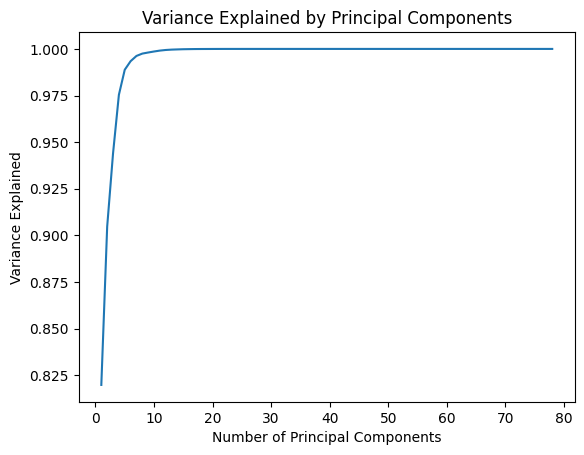

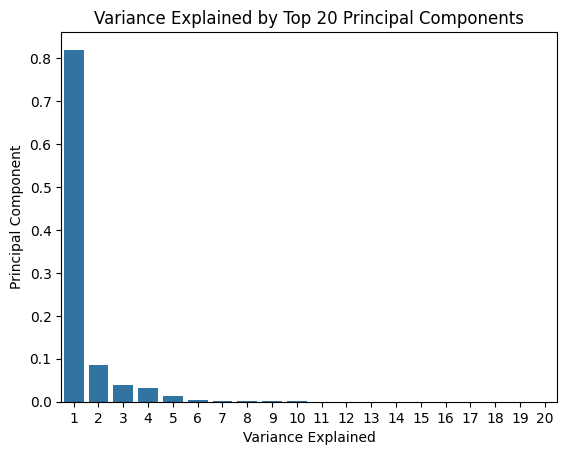

In [7]:
from sklearn.decomposition import PCA

#check data types of each column
types = []
for column in data.columns:
    types.append(data[column].dtype)

print(set(types))


# Analyze the variance explained by each principal component
pca = PCA()
pca.fit(X)

# Plot the variance explained by each principal component

print(pca.explained_variance_ratio_)
plt.plot(range(1, len(X.columns) + 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Principal Components')
plt.show()

#plot the top 20 features
import seaborn
seaborn.barplot(x=range(1, 21), y=pca.explained_variance_ratio_[:20])
plt.xlabel('Variance Explained')
plt.ylabel('Principal Component')
plt.title('Variance Explained by Top 20 Principal Components')
plt.show()


In [8]:
# Determine Number of Feautures to Keep to ensure 99 percent of variance is explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_over_99 = len(cumulative_variance[cumulative_variance < .99])

print(f"Number of features to retain 99% variance: {n_over_99}")

# Perform PCA with the number of features determined above
pca = PCA(n_components=n_over_99)
pca.fit(X)
transformed_data = pca.transform(X)

# Convert the transformed data into a DataFrame with column names
transformed_data = pd.DataFrame(transformed_data)



# Add the target column to the transformed data
transformed_data['Label'] = y.values

# Display the first 5 rows of the transformed data
transformed_data.head()

Number of features to retain 99% variance: 5


,0,1,2,3,4,Label
0,-5.963704e+07,-1.487636e+06,-1.065679e+06,-4.336922e+06,-854921.068344,BENIGN
1,-5.967151e+07,-1.487352e+06,-2.655634e+04,-4.308066e+06,-865449.528673,BENIGN
2,-5.969172e+07,-1.501312e+06,4.683529e+06,-4.117788e+06,-863022.076024,BENIGN
3,-5.963788e+07,-1.472626e+06,-4.004649e+05,-4.321812e+06,-877760.278077,BENIGN
4,-5.969131e+07,-1.501683e+06,4.701203e+06,-4.117351e+06,-863920.530371,BENIGN


By doing PCA, we have created 5 new features that are linear combinations of the original features.

#### Data Preprocessing and Preparation
We need to create two different datasets, one for training and the other for testing. Since we have a very large dataset, we can afford to keep 10% of the data for validation, 10% for testing, and 80% for training.

We will also standardize the data, to center the data around its mean and scale it base on the standard deviation.


In [ ]:
#convert output labels to numerical values
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

use_new_data = False
if use_new_data or not os.path.exists("transformed_data.csv"):
    print("Transforming data...")
    label_encoder = LabelEncoder()
    transformed_data['Label'] = label_encoder.fit_transform(transformed_data['Label'])

    #standardize the data
    scaler = StandardScaler()
    transformed_data[transformed_data.columns[:-1]] = scaler.fit_transform(transformed_data[transformed_data.columns[:-1]])

    #save the transformed data to a csv file
    output_file = "transformed_data.csv"
    if os.path.exists(output_file):
        os.remove(output_file)
    transformed_data.to_csv(output_file, index=False)
else:
    #load the transformed data from a csv file
    print("Loading transformed data from csv file...")
    transformed_data = pd.read_csv("transformed_data.csv")


transformed_data.head()

Loading transformed data from csv file...


,0,1,2,3,4,Label
0,-0.589819,-0.046262,-0.047402,-0.219198,-0.066335,0
1,-0.590159,-0.046253,-0.000258,-0.217681,-0.067175,0
2,-0.590356,-0.046679,0.213428,-0.207797,-0.066997,0
3,-0.589827,-0.045799,-0.017222,-0.218402,-0.068131,0
4,-0.590352,-0.046690,0.214230,-0.207775,-0.067067,0


In [10]:

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(transformed_data[transformed_data.columns[:-1]], transformed_data['Label'], test_size=0.2, random_state=0)

# Split the test data into testing and validation sets
validation_X = X_test.sample(frac=0.5, random_state=0)
testing_X = X_test.drop(validation_X.index)

validation_y = y_test.loc[validation_X.index]
testing_y = y_test.loc[testing_X.index]

# Display the number of data points in the training set
print(f"Number of data points in the training set: {len(transformed_data)}")
print(f"Number of data points in the testing set: {len(testing_X)}")
print(f"Number of data points in the validation set: {len(validation_X)}")




Number of data points in the training set: 1823202
Number of data points in the testing set: 182321
Number of data points in the validation set: 182320


#### Model Selection

We will use two different types of models, Neural Networks and Random Forests, to predict the type of attack. We will use the F1 score as the metric to evaluate the models.

#### Random Forest Classifier

We will start with the Random Forest Classifier, a collection of Decision Trees that will each output a prediction and the model will take the majority vote as the final prediction.

In [11]:
import tqdm
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import TensorDataset, DataLoader
import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

#must define model before it is loaded from pickle file
class NNModel():
    def __init__(self, input_dim, hidden_dim, learning_rate):
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 3)
        )

        self.model.to(device)
    
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def evaluate(self, test_loader):
        self.model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                output = self.model(X_batch)
                _, predicted = torch.max(output, dim=1)
                total += y_batch.size(0)
                correct += int((predicted == y_batch).sum())

            accuracy = correct / total
            return accuracy

    def train(self, train_loader, num_epochs):
        for epoch in range(num_epochs):
            self.model.train()
            running_loss = 0.0
            for X_batch, y_batch in tqdm.tqdm(train_loader):
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                self.optimizer.zero_grad()
                output = self.model(X_batch)
                loss = self.criterion(output, y_batch)
                running_loss += loss.item()
                loss.backward()
                self.optimizer.step()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")


        print(f"Training Accuracy: {self.evaluate(train_loader)}")


    



Using device: cuda


In [ ]:
retrain_rf = False
retrain_nn = False


rfc = None # Random Forest Classifier
model = None # Neural Network

if os.path.exists("session.pkl"):
    with open("session.pkl", "rb") as f:
        loaded = pickle.load(f)
        rfc = loaded['rfc']
        model = loaded['nn']
else: 
    retrain_rf = True
    retrain_nn = True
    print("Training new models...")


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pickle

print(retrain_rf or not os.path.exists("rfc_model.pkl"))

if retrain_rf:
    print("Training a new model...")
    # Train a Random Forest classifier
    rfc = RandomForestClassifier(random_state=0)
    rfc.fit(X_train, y_train)
else:
    print("Loading the trained model...")

# Make predictions on the testing set
y_pred = rfc.predict(testing_X)

# Make predictions on the training set (to check for overfitting)
train_y_pred = rfc.predict(X_train)


True
Loading the trained model...


In [14]:
# Calculate the train accuracy of the classifier
train_accuracy = accuracy_score(y_train, train_y_pred)
print(f"Training Accuracy: {train_accuracy}\n")

# Calculate the test accuracy of the classifier
accuracy = accuracy_score(testing_y, y_pred)
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision_score(testing_y, y_pred, average='weighted')}")
print(f"Testing Recall: {recall_score(testing_y, y_pred, average='weighted')}")
print(f"Testing F1 Score: {f1_score(testing_y, y_pred, average='weighted')}")

Training Accuracy: 0.9790814371150743

Testing Accuracy: 0.9768924040565815
Testing Precision: 0.9776204751243049
Testing Recall: 0.9768924040565815
Testing F1 Score: 0.9768279627928179


This accuracy is abnormally high, so we can try to improve the model by using a Neural Network.

It is possible that the characteristics of these kind of attacks are very apparent in the data, so we could test the model on a diferent dataset of other kinds of attacks to see if the model works on those.

#### Neural Network
To train the Neural Network, we will start by creating a TensorDataset object for both the train and test sets. We will use the DataLoader object to load the data in batches.

In [15]:
X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).long()

X_test_tensor = torch.tensor(testing_X.values).float()
y_test_tensor = torch.tensor(testing_y.values).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


In [16]:


if retrain_nn:
    print("Training a new model...")
    model = NNModel(input_dim=X_train_tensor.shape[1], hidden_dim=128, learning_rate=0.001)
    model.train(train_loader, num_epochs=30)
else:
    print("Using the trained model...")

print(f"Testing Accuracy: {model.evaluate(test_loader)}")

Training a new model...


100%|██████████| 1425/1425 [00:13<00:00, 104.60it/s]


Epoch 1/30, Loss: 0.4381308354620348


100%|██████████| 1425/1425 [00:11<00:00, 126.55it/s]


Epoch 2/30, Loss: 0.37179211541226037


100%|██████████| 1425/1425 [00:11<00:00, 126.56it/s]


Epoch 3/30, Loss: 0.35858170216543633


100%|██████████| 1425/1425 [00:11<00:00, 126.68it/s]


Epoch 4/30, Loss: 0.3409205311850498


100%|██████████| 1425/1425 [00:11<00:00, 126.50it/s]


Epoch 5/30, Loss: 0.3202165551771197


100%|██████████| 1425/1425 [00:11<00:00, 126.39it/s]


Epoch 6/30, Loss: 0.2995548510237744


100%|██████████| 1425/1425 [00:11<00:00, 119.53it/s]


Epoch 7/30, Loss: 0.2804608070432094


100%|██████████| 1425/1425 [00:11<00:00, 118.79it/s]


Epoch 8/30, Loss: 0.2636586900970392


100%|██████████| 1425/1425 [00:11<00:00, 125.58it/s]


Epoch 9/30, Loss: 0.25380579510278867


100%|██████████| 1425/1425 [00:11<00:00, 126.68it/s]


Epoch 10/30, Loss: 0.24298867281068837


100%|██████████| 1425/1425 [00:11<00:00, 126.85it/s]


Epoch 11/30, Loss: 0.23738887289114166


100%|██████████| 1425/1425 [00:11<00:00, 126.55it/s]


Epoch 12/30, Loss: 0.23597876794505537


100%|██████████| 1425/1425 [00:11<00:00, 126.96it/s]


Epoch 13/30, Loss: 0.23456987665410628


100%|██████████| 1425/1425 [00:12<00:00, 116.94it/s]


Epoch 14/30, Loss: 0.22874125247461755


100%|██████████| 1425/1425 [00:13<00:00, 107.57it/s]


Epoch 15/30, Loss: 0.22581015023223142


100%|██████████| 1425/1425 [00:11<00:00, 126.15it/s]


Epoch 16/30, Loss: 0.22114594551554898


100%|██████████| 1425/1425 [00:11<00:00, 126.10it/s]


Epoch 17/30, Loss: 0.2196262812614441


100%|██████████| 1425/1425 [00:11<00:00, 121.27it/s]


Epoch 18/30, Loss: 0.21836505479979934


100%|██████████| 1425/1425 [00:11<00:00, 120.52it/s]


Epoch 19/30, Loss: 0.2124280253627844


100%|██████████| 1425/1425 [00:13<00:00, 108.96it/s]


Epoch 20/30, Loss: 0.2159217264254888


100%|██████████| 1425/1425 [00:11<00:00, 122.78it/s]


Epoch 21/30, Loss: 0.2174969793934571


100%|██████████| 1425/1425 [00:11<00:00, 128.65it/s]


Epoch 22/30, Loss: 0.21119239006126136


100%|██████████| 1425/1425 [00:11<00:00, 128.48it/s]


Epoch 23/30, Loss: 0.21114621469849035


100%|██████████| 1425/1425 [00:11<00:00, 128.87it/s]


Epoch 24/30, Loss: 0.21170933374187403


100%|██████████| 1425/1425 [00:11<00:00, 125.05it/s]


Epoch 25/30, Loss: 0.21124885531893947


100%|██████████| 1425/1425 [00:11<00:00, 122.73it/s]


Epoch 26/30, Loss: 0.21709178611897587


100%|██████████| 1425/1425 [00:11<00:00, 123.10it/s]


Epoch 27/30, Loss: 0.2123305689765696


100%|██████████| 1425/1425 [00:11<00:00, 124.00it/s]


Epoch 28/30, Loss: 0.21435814680760368


100%|██████████| 1425/1425 [00:11<00:00, 125.50it/s]


Epoch 29/30, Loss: 0.21238204493857266


100%|██████████| 1425/1425 [00:11<00:00, 125.62it/s]


Epoch 30/30, Loss: 0.21224242994659825
Training Accuracy: 0.9253819346602576
Testing Accuracy: 0.9249784720355856


10 Epochs:
Training Accuracy: 0.9071488953838749
Testing Accuracy: 0.9067249521448434

20 Epochs:
Training Accuracy: 0.9227485172029144
Testing Accuracy: 0.9224664191179294


30 Epochs:


#### Save the Models

In [17]:
session = {
    'rfc': rfc,
    'nn': model
}

# Save the session to a file
with open('session.pkl', 'wb') as f:
    pickle.dump(session, f)



#### Validation
Now we can test both models on the validation set to make sure that they can be generalized to a new set of data

In [18]:
#test both models on the validation set
validation_X_tensor = torch.tensor(validation_X.values).float()
validation_y_tensor = torch.tensor(validation_y.values).long()
validation_dataset = TensorDataset(validation_X_tensor, validation_y_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=1024, shuffle=False)
print(f"Validation Accuracy (RFC): {rfc.score(validation_X, validation_y)}")
print(f"Validation Accuracy (NN): {model.evaluate(validation_loader)}")


Validation Accuracy (RFC): 0.976974550241334
Validation Accuracy (NN): 0.9255430013163668
